In [1]:
!pip install pandas numpy matplotlib seaborn scikit-learn imblearn xgboost


In [2]:
#Loarding Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.feature_selection import SelectKBest, f_classif


In [3]:
#Load and preprocess data
df = pd.read_csv('/content/healthcare-dataset-stroke-data.csv')
df.drop('id', axis=1, inplace=True)

In [4]:
# Check for missing values
print(df.isnull().sum())

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


In [5]:
#Handle missing values and data exploration
df['bmi'] = df['bmi'].astype(float)
df['bmi'].fillna(df['bmi'].median(), inplace=True)  # Impute missing 'bmi' with median


<ipython-input-5-f2911349d438>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['bmi'].fillna(df['bmi'].median(), inplace=True)  # Impute missing 'bmi' with median


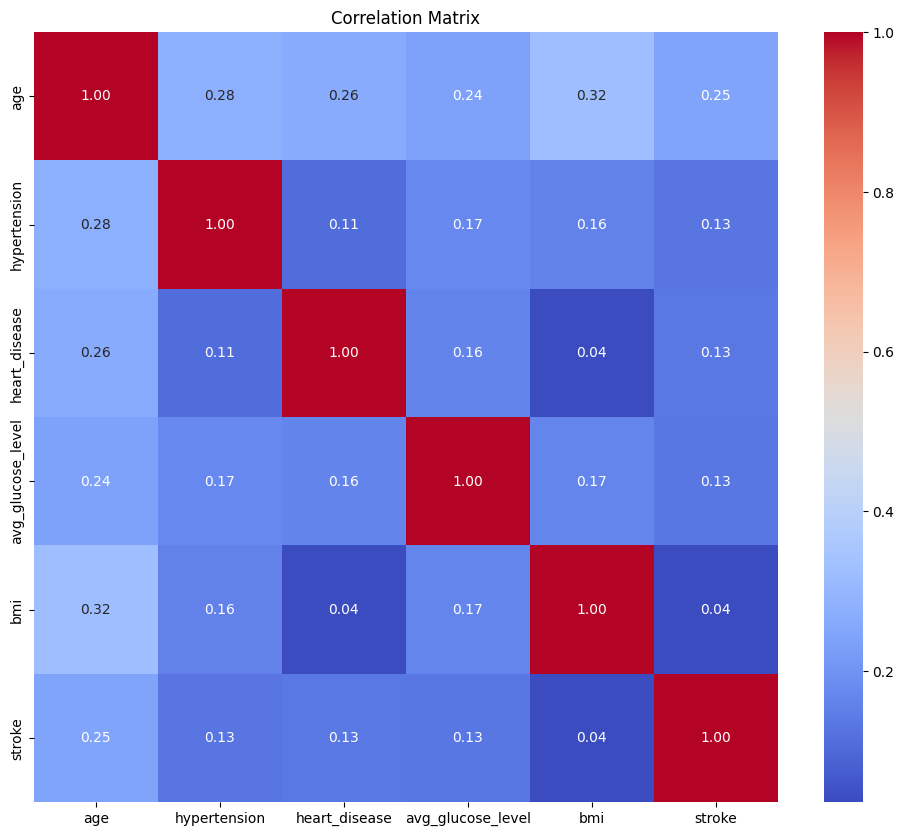

In [6]:
# Data Exploration (Correlation Matrix and Visualizations)
numerical_df = df.select_dtypes(include=np.number)
correlation_matrix = numerical_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

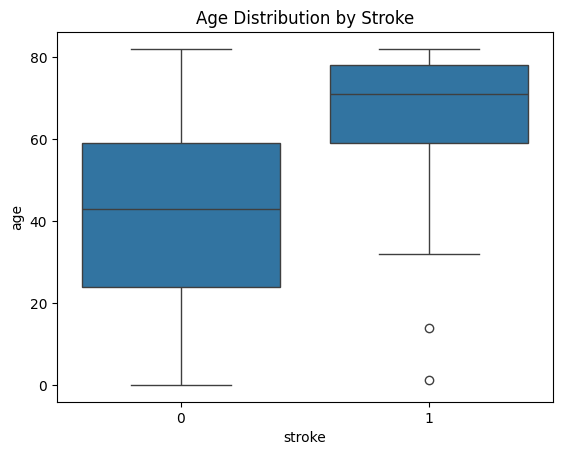

In [7]:
sns.boxplot(x='stroke', y='age', data=df)
plt.title("Age Distribution by Stroke")
plt.show()

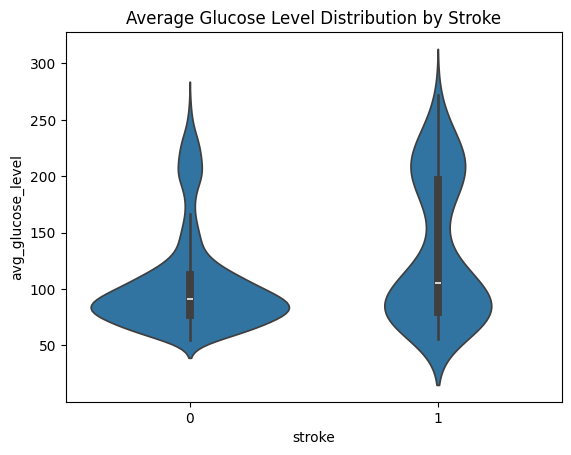

In [8]:
sns.violinplot(x='stroke', y='avg_glucose_level', data=df)
plt.title("Average Glucose Level Distribution by Stroke")
plt.show()

Number of outliers in 'avg_glucose_level': 627
Outlier values:
0       228.69
1       202.21
3       171.23
4       174.12
5       186.21
         ...  
5061    223.78
5062    211.58
5063    179.38
5064    193.88
5076    174.37
Name: avg_glucose_level, Length: 627, dtype: float64


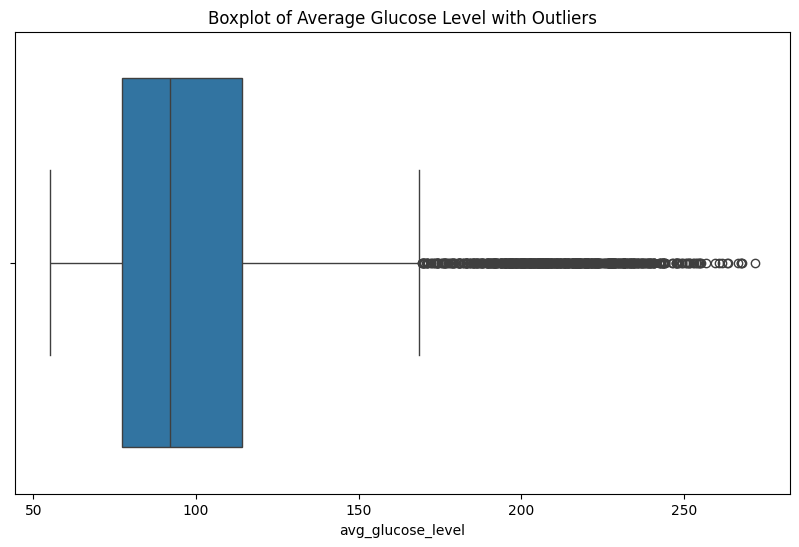

In [9]:
#check avg_glucose_level column contain outliers

# Calculate the IQR for 'avg_glucose_level'
Q1 = df['avg_glucose_level'].quantile(0.25)
Q3 = df['avg_glucose_level'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = df[(df['avg_glucose_level'] < lower_bound) | (df['avg_glucose_level'] > upper_bound)]

# Print the number of outliers
print(f"Number of outliers in 'avg_glucose_level': {len(outliers)}")

# Print the outlier values (optional)
print("Outlier values:")
print(outliers['avg_glucose_level'])

# Visualize the outliers (optional)
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['avg_glucose_level'])
plt.title("Boxplot of Average Glucose Level with Outliers")
plt.show()

In [10]:
# Remove rows where 'avg_glucose_level' is an outlier
df_no_outliers = df[(df['avg_glucose_level'] >= lower_bound) & (df['avg_glucose_level'] <= upper_bound)]

In [11]:
#One-Hot Encoding for categorical features
cat_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

In [12]:
# Check if all columns in cat_cols exist in the DataFrame
missing_cols = [col for col in cat_cols if col not in df.columns]
if missing_cols:
    raise KeyError(f"The following columns are missing in the DataFrame: {missing_cols}")

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_data = encoder.fit_transform(df[cat_cols])
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(cat_cols))
df = pd.concat([df, encoded_df], axis=1)
df.drop(cat_cols, axis=1, inplace=True)

In [13]:
#Feature scaling for numerical features
num_cols = ['age', 'avg_glucose_level', 'bmi']
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])


In [14]:
#Feature Selection using SelectKBest
X = df.drop('stroke', axis=1)
y = df['stroke']

selector = SelectKBest(score_func=f_classif, k=10)  # Select top 10 features
X_new = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]
X = X[selected_features]  # Update X with selected features

Class Distribution:
stroke
0    4861
1     249
Name: count, dtype: int64

Class Percentages:
stroke
0    95.127202
1     4.872798
Name: count, dtype: float64


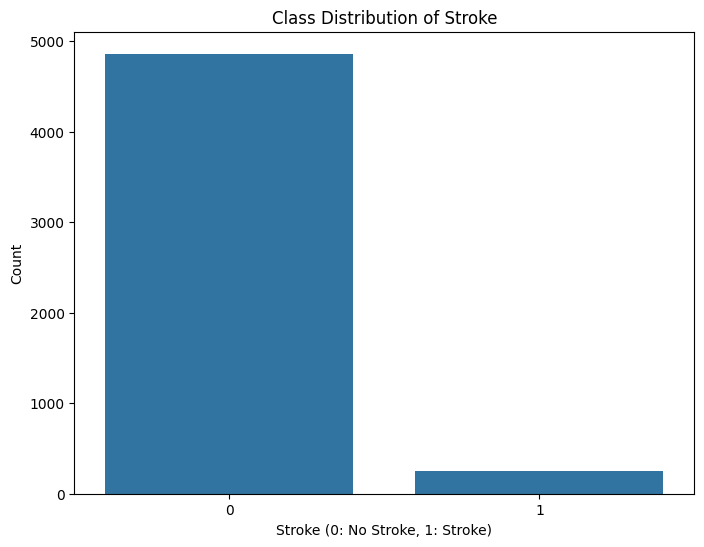

In [15]:
# Count the occurrences of each class in the 'stroke' column
stroke_counts = df['stroke'].value_counts()

# Print the class distribution
print("Class Distribution:")
print(stroke_counts)

# Calculate and print the percentage of each class
print("\nClass Percentages:")
print(stroke_counts / len(df) * 100)

# Visualize the class distribution (optional)
plt.figure(figsize=(8, 6))
sns.countplot(x='stroke', data=df)
plt.title('Class Distribution of Stroke')
plt.xlabel('Stroke (0: No Stroke, 1: Stroke)')
plt.ylabel('Count')
plt.show()

In [16]:
#Handle class imbalance using SMOTE
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X, y)



Class Distribution After SMOTE:
stroke
1    4861
0    4861
Name: count, dtype: int64

Class Percentages After SMOTE:
stroke
1    50.0
0    50.0
Name: count, dtype: float64


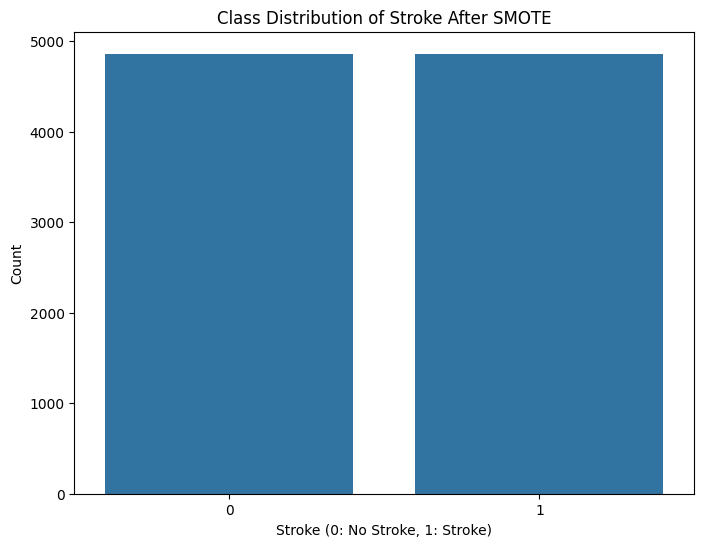

In [17]:
# Check the class distribution after SMOTE
print("\nClass Distribution After SMOTE:")
print(pd.Series(y_resampled).value_counts())

# Calculate and print the percentage of each class after SMOTE
print("\nClass Percentages After SMOTE:")
print(pd.Series(y_resampled).value_counts() / len(y_resampled) * 100)


# Visualize the class distribution after SMOTE (optional)
plt.figure(figsize=(8, 6))
sns.countplot(x=y_resampled)
plt.title('Class Distribution of Stroke After SMOTE')
plt.xlabel('Stroke (0: No Stroke, 1: Stroke)')
plt.ylabel('Count')
plt.show()


In [18]:
!pip install scikit-learn==1.2.2

In [19]:
#Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

#Define and train models with hyperparameter optimization
from sklearn.model_selection import RandomizedSearchCV  # Import RandomizedSearchCV

def train_and_evaluate_model(model, model_name, param_grid):
    print(f"Training {model_name}...")
    # Use RandomizedSearchCV for hyperparameter tuning
    random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=10, cv=5, scoring='roc_auc', random_state=42)
    random_search.fit(X_train, y_train)
    best_model = random_search.best_estimator_  # Get the best model

    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model_name} Accuracy: {accuracy:.2f}")
    print(classification_report(y_test, y_pred))
    return best_model, accuracy

# Define parameter grids for each model
logistic_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Train and evaluate models
logistic_model, logistic_acc = train_and_evaluate_model(LogisticRegression(random_state=42, max_iter=1000), "Logistic Regression", logistic_param_grid)
rf_model, rf_acc = train_and_evaluate_model(RandomForestClassifier(random_state=42), "Random Forest", rf_param_grid)
xgb_model, xgb_acc = train_and_evaluate_model(XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'), "XGBoost", xgb_param_grid)

Training Logistic Regression...
Logistic Regression Accuracy: 0.77
              precision    recall  f1-score   support

           0       0.80      0.74      0.77       975
           1       0.75      0.81      0.78       970

    accuracy                           0.77      1945
   macro avg       0.78      0.77      0.77      1945
weighted avg       0.78      0.77      0.77      1945

Training Random Forest...
Random Forest Accuracy: 0.91
              precision    recall  f1-score   support

           0       0.92      0.89      0.90       975
           1       0.89      0.92      0.91       970

    accuracy                           0.91      1945
   macro avg       0.91      0.91      0.91      1945
weighted avg       0.91      0.91      0.91      1945

Training XGBoost...


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [10:09:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [10:09:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [10:09:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [10:09:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [10:09:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

XGBoost Accuracy: 0.91
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       975
           1       0.90      0.92      0.91       970

    accuracy                           0.91      1945
   macro avg       0.91      0.91      0.91      1945
weighted avg       0.91      0.91      0.91      1945



In [20]:

def evaluate_model(model, model_name, X_test, y_test):
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    print(f"{model_name} ROC AUC: {roc_auc:.2f}")
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend(loc="lower right")
    plt.show()


Logistic Regression ROC AUC: 0.85


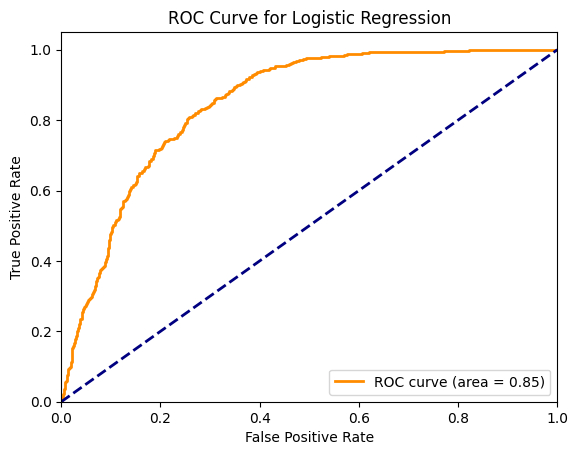

Random Forest ROC AUC: 0.97


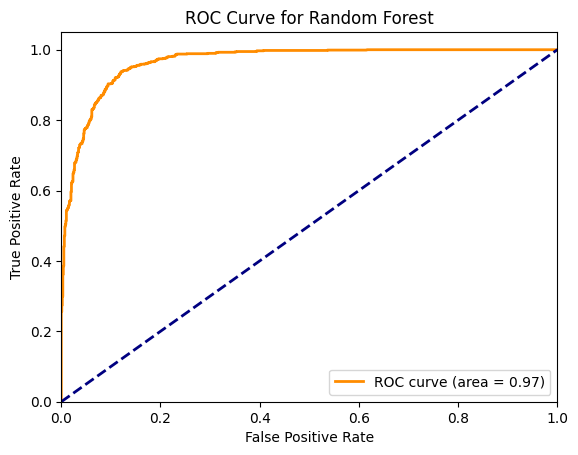

XGBoost ROC AUC: 0.98


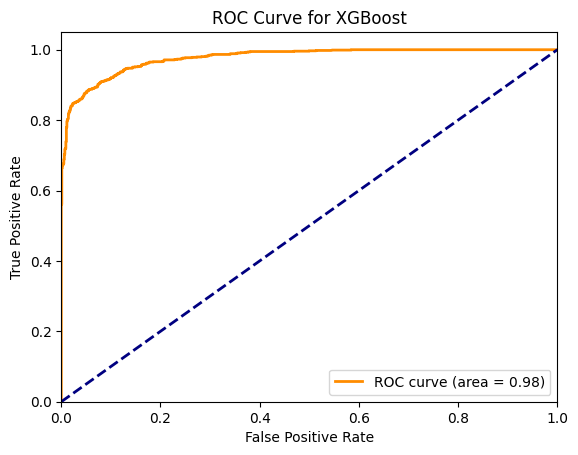

In [21]:
#Evaluate models and plot ROC curves
evaluate_model(logistic_model, "Logistic Regression", X_test, y_test)
evaluate_model(rf_model, "Random Forest", X_test, y_test)
evaluate_model(xgb_model, "XGBoost", X_test, y_test)

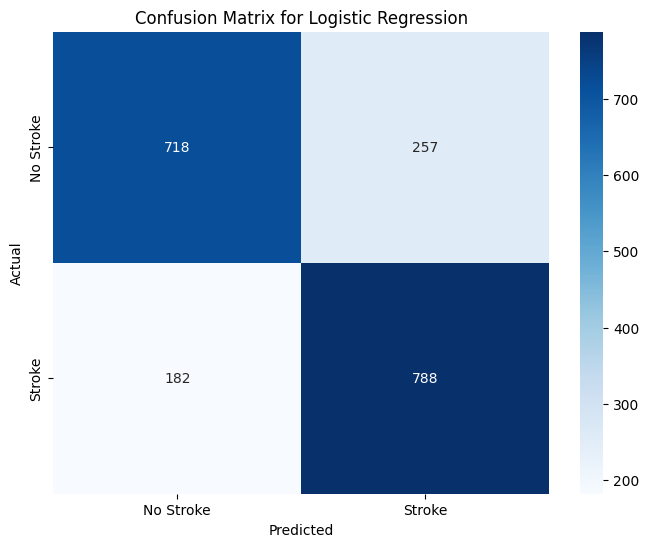

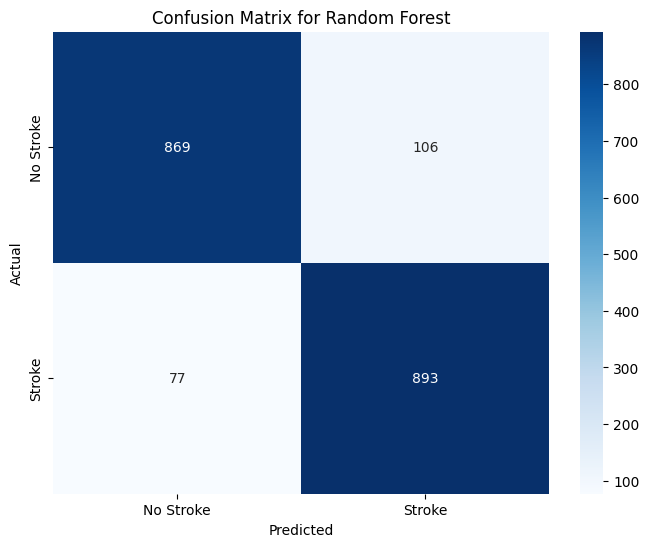

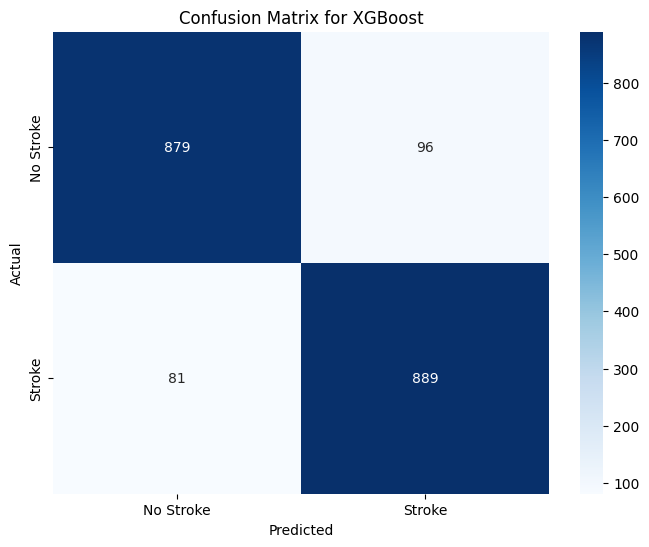

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=['No Stroke', 'Stroke'],
                yticklabels=['No Stroke', 'Stroke'])
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Plot confusion matrices for each model
plot_confusion_matrix(logistic_model, X_test, y_test, "Logistic Regression")
plot_confusion_matrix(rf_model, X_test, y_test, "Random Forest")
plot_confusion_matrix(xgb_model, X_test, y_test, "XGBoost")

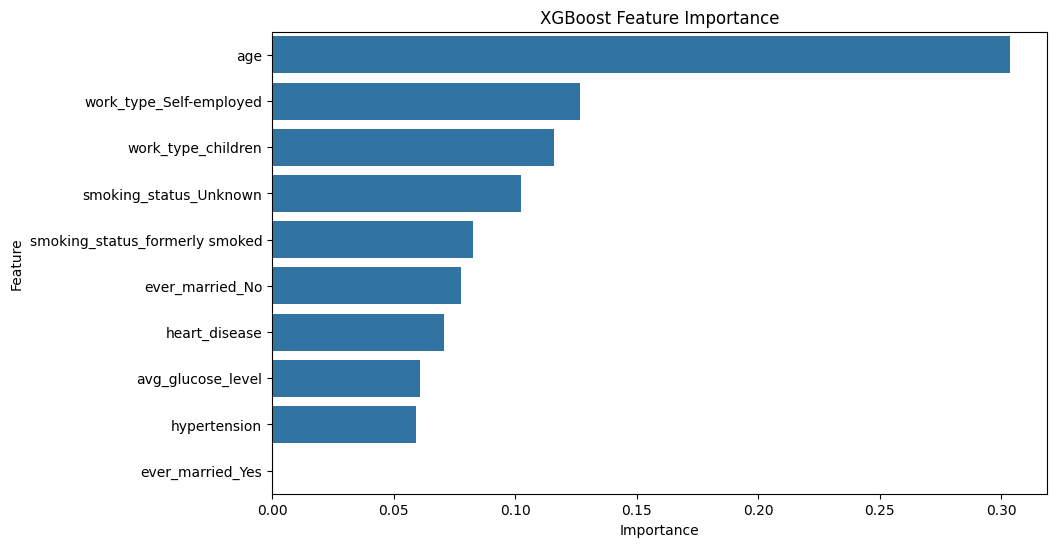

In [22]:
#Plot feature importance for XGBoost
xgb_feature_importance = xgb_model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': xgb_feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('XGBoost Feature Importance')
plt.show()

In [24]:
#Make custom predictions
def make_prediction(input_data, threshold=0.4):  # Adjust threshold here
    # Create a DataFrame with the custom input
    input_df = pd.DataFrame([input_data])

    # One-Hot Encoding for categorical features in custom input
    cat_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

    # Check if all columns in cat_cols exist in input_df:
    missing_cols = [col for col in cat_cols if col not in input_df.columns]
    if missing_cols:
        raise KeyError(f"The following columns are missing in the input data: {missing_cols}")

    encoded_data = encoder.transform(input_df[cat_cols])  # Use the fitted encoder
    encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(cat_cols))
    input_df = pd.concat([input_df, encoded_df], axis=1)
    input_df.drop(cat_cols, axis=1, inplace=True)

    # Feature scaling for numerical features in custom input
    num_cols = ['age', 'avg_glucose_level', 'bmi']
    input_df[num_cols] = scaler.transform(input_df[num_cols])  # Use the fitted scaler

    # Select only the features used in the model
    input_df = input_df[selected_features]  # Use selected_features from Step 5

    # Make prediction
    prediction_probability = xgb_model.predict_proba(input_df)[0][1]  # Probability of stroke
    prediction = 1 if prediction_probability >= threshold else 0
    print(f"Predicted Stroke Risk: {'Yes' if prediction == 1 else 'No'}")
    print(f"Stroke Probability: {prediction_probability:.2f}")

# Example custom input
custom_input = {
    "gender": "Female",  # Changed to string
    "age": 50,
    "hypertension": 0,
    "heart_disease": 0,
    "ever_married": "Yes",  # Changed to string
    "work_type": "Private",  # Changed to string
    "Residence_type": "Urban",  # Changed to string
    "avg_glucose_level": 193.94,
    "bmi": 22.4,
    "smoking_status": "formerly smoked"  # Changed to string
}

make_prediction(custom_input, threshold=0.3)

Predicted Stroke Risk: No
Stroke Probability: 0.06
